Теоретическая часть 

1) User-User предсказвает рейтинг текущего пользователя. Товары являются признаками для пользователей. Item-Item тоже сомое, только ищем похожие товары. Пользователи являются признаками для товаров. Также сходство найти подходящий товар или же подходящего юзера. Отличие - user_user метод довольно чувствительным к любым зарегистрированным взаимодействиям (высокая дисперсия), так как взаимодействие только по нескольким пунктам, однако более персонолизированный подзход. В item - item - все наоборот

 функция item_item_rec(interaction_matrix) можно использовать в User_User_rec, так как подходы похожи (только отзеркалены друг против друга). Нужно лишь транпонировать матрицу

Разные методики подсчета. В item-item параметры алгоритма задаются вручную, в ALS сам корректирует коэффициенты при поступлении новых данных.

2) количество комментариев

количество просмотров

количество лайков у товаров

3) ALS - модель линейного взаимодействия

только позитивные взаимодействия - если не было покупки , модель не сможет адекватно предсказать наши действия

ALS не учитывает зависимость во времени

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
import os, sys

module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
#from src.metrics import precision_at_k, recall_at_k

In [2]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list  # Тут нет [:k] !!
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision

In [3]:
#data = pd.read_csv(root+'transaction_data.csv')
data = pd.read_csv('retail_train.csv')
data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)


test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [4]:
item_features = pd.read_csv('product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [5]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [6]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [7]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [8]:
user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробоват ьдругие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
%%time

csr_mat = csr_matrix(user_item_matrix).T.tocsr()

model = AlternatingLeastSquares(factors=44, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                use_gpu=False)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=csr_matrix(user_item_matrix).tocsr(),   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=None, 
                        recalculate_user=True)

  0%|          | 0/15 [00:00<?, ?it/s]

Wall time: 778 ms


In [10]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [11]:
statistic = dict()

In [12]:
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))
statistic['general'] = result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

In [13]:
%%time

user_item_matrix = tfidf_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_tfidf'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

statistic['tf-idf'] = result.apply(lambda row: precision_at_k(row['als_tfidf'], row['actual']), axis=1).mean()

  0%|          | 0/15 [00:00<?, ?it/s]

Wall time: 12.5 s


In [14]:
# Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', 
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

user_item_matrix = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
          show_progress=True)

result['als_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

statistic['bm25'] = result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean()

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  0%|          | 0/15 [00:00<?, ?it/s]

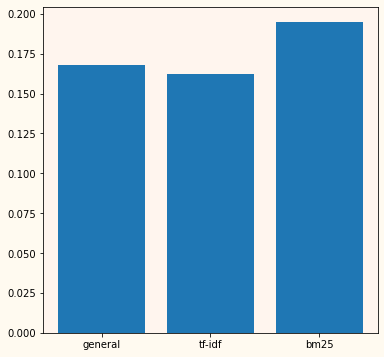

In [15]:
fig, ax = plt.subplots()

ax.bar(statistic.keys(), statistic.values())

ax.set_facecolor('seashell')
fig.set_facecolor('floralwhite')
fig.set_figwidth(6)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure

plt.show()

Оптимизация параметров

In [16]:
import time

statistic_precision = list()
statistic_time = list()
n_factors = np.arange(50, 350, 50) 

result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

for n in n_factors:
    # Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
    data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

    user_item_matrix = pd.pivot_table(data_train, 
                                      index='user_id', columns='item_id', 
                                      values='quantity', # Можно пробоват ьдругие варианты
                                      aggfunc='count', 
                                      fill_value=0
                                     )

    user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

    # переведем в формат saprse matrix
    sparse_user_item = csr_matrix(user_item_matrix).tocsr()

    user_item_matrix.head(3)

    user_item_matrix = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

    start_time = time.time()
    
    model = AlternatingLeastSquares(factors=n, 
                                    regularization=0.001,
                                    iterations=15, 
                                    calculate_training_loss=True, 
                                    num_threads=4) # K - кол-во билжайших соседей

    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
              show_progress=True)
    
    end_time = time.time()

    result[f'factors={n}'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

    statistic_precision.append(result.apply(lambda row: precision_at_k(row[f'factors={n}'], row['actual']), axis=1).mean())
    statistic_time.append(end_time - start_time)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

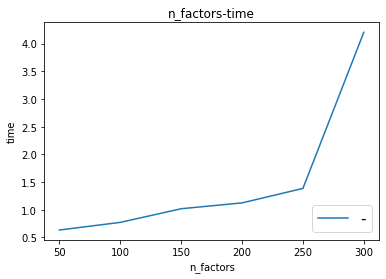

In [17]:
plt.plot(n_factors, statistic_time, label='-')

plt.xlabel('n_factors')
plt.ylabel('time')
plt.title('n_factors-time')
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

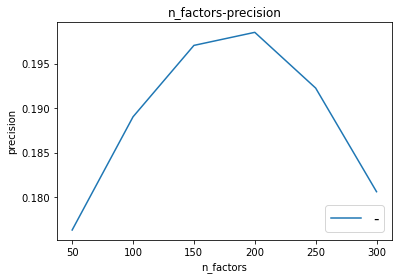

In [18]:
plt.plot(n_factors, statistic_precision, label='-')

plt.xlabel('n_factors')
plt.ylabel('precision')
plt.title('n_factors-precision')
plt.legend(loc="lower right", prop={'size': 15})
plt.show()

In [19]:
import time

statistic_precision = list()
statistic_time = list()
n_regularization = [10, 1, 0.1, 0.01, 0.001, 0.0001]

result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

for n in n_regularization:
    # Заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
    data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

    user_item_matrix = pd.pivot_table(data_train, 
                                      index='user_id', columns='item_id', 
                                      values='quantity', # Можно пробоват ьдругие варианты
                                      aggfunc='count', 
                                      fill_value=0
                                     )

    user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

    # переведем в формат saprse matrix
    sparse_user_item = csr_matrix(user_item_matrix).tocsr()

    user_item_matrix.head(3)

    user_item_matrix = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

    start_time = time.time()
    
    model = AlternatingLeastSquares(factors=200, 
                                    regularization=n,
                                    iterations=15, 
                                    calculate_training_loss=True, 
                                    num_threads=4) # K - кол-во билжайших соседей

    model.fit(csr_matrix(user_item_matrix).T.tocsr(),  # На вход item-user matrix
              show_progress=True)
    
    end_time = time.time()

    result[f'factors={n}'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

    statistic_precision.append(result.apply(lambda row: precision_at_k(row[f'factors={n}'], row['actual']), axis=1).mean())
    statistic_time.append(end_time - start_time)

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

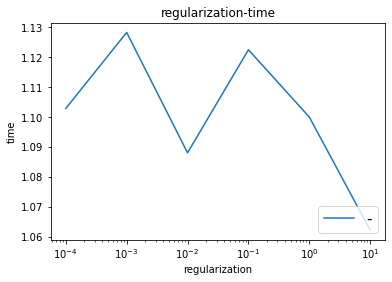

In [20]:
plt.plot(n_regularization, statistic_time, label='-')

plt.xlabel('regularization')
plt.ylabel('time')
plt.title('regularization-time')
plt.legend(loc="lower right", prop={'size': 15})
plt.xscale('log')
plt.show()

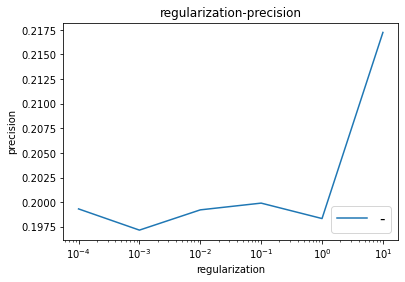

In [21]:
plt.plot(n_regularization, statistic_precision, label='-')

plt.xlabel('regularization')
plt.ylabel('precision')
plt.title('regularization-precision')
plt.legend(loc="lower right", prop={'size': 15})
plt.xscale('log')
plt.show()

Увеличение времени работы при увеличении факторов.При 200 скрытых факторов модель достигает большей точности. Регуляризация не влияет на скорость и время обучения модели. Точность возрастала при увеличении коэф. регуляризации.